In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


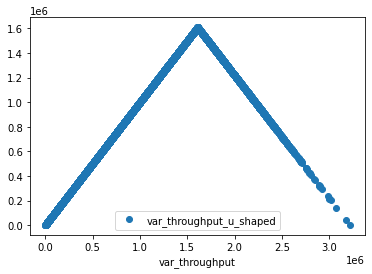

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL1'
special_option = 'SP1'
k_option_for_tp = 1

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [7]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [10]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [11]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [12]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [13]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=15,
                  validation_data=(X_test, y_test_rapport), 
                  callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 2s 28ms/step - loss: 0.6933 - accuracy: 0.6148 - f1_m: 0.6155 - recall_m: 0.6689 - precision_m: 0.5794 - val_loss: 0.6936 - val_accuracy: 0.1288 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/15
72/72 [==============================] - 2s 23ms/step - loss: 0.6932 - accuracy: 0.5277 - f1_m: 0.5374 - recall_m: 0.5476 - precision_m: 0.5970 - val_loss: 0.6883 - val_accuracy: 0.8712 - val_f1_m: 0.9305 - val_recall_m: 1.0000 - val_precision_m: 0.8704
Epoch 3/15
72/72 [==============================] - 2s 23ms/step - loss: 0.6925 - accuracy: 0.8284 - f1_m: 0.8945 - recall_m: 0.9546 - precision_m: 0.8599 - val_loss: 0.7149 - val_accuracy: 0.1649 - val_f1_m: 0.0876 - val_recall_m: 0.0463 - val_precision_m: 0.8999


In [14]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

(0.5161277218069549, 0.5061557492423759, 0.15897436896191422, None)

In [15]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=15,
                   validation_data=(X_test, y_test_gamemove), 
                   callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 2s 28ms/step - loss: 0.6933 - accuracy: 0.3189 - f1_m: 0.2952 - recall_m: 0.3007 - precision_m: 0.3183 - val_loss: 0.6946 - val_accuracy: 0.0624 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/15
72/72 [==============================] - 2s 24ms/step - loss: 0.6931 - accuracy: 0.2604 - f1_m: 0.2482 - recall_m: 0.2292 - precision_m: 0.4300 - val_loss: 0.6902 - val_accuracy: 0.6293 - val_f1_m: 0.7627 - val_recall_m: 0.6389 - val_precision_m: 0.9486
Epoch 3/15
72/72 [==============================] - 2s 24ms/step - loss: 0.6912 - accuracy: 0.7780 - f1_m: 0.8490 - recall_m: 0.8121 - precision_m: 0.9366 - val_loss: 0.6541 - val_accuracy: 0.6706 - val_f1_m: 0.7961 - val_recall_m: 0.6876 - val_precision_m: 0.9474
Epoch 4/15
72/72 [==============================] - 2s 24ms/step - loss: 0.6843 - accuracy: 0.4343 - f1_m: 0.5590 - recall_m: 0.4108 - precision_m: 0.9565 - val_loss: 0.6021 - val_accuracy: 0.5

In [16]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.5105005873115177, 0.5434657664561477, 0.35450406174379495, None)

In [17]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=15,
                    validation_data=(X_test, y_test_reasoning), 
                    callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 2s 28ms/step - loss: 0.6934 - accuracy: 0.5882 - f1_m: 0.5671 - recall_m: 0.6250 - precision_m: 0.5193 - val_loss: 0.6916 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 2/15
72/72 [==============================] - 2s 24ms/step - loss: 0.6932 - accuracy: 0.6819 - f1_m: 0.7015 - recall_m: 0.7632 - precision_m: 0.7225 - val_loss: 0.6900 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 3/15
72/72 [==============================] - 2s 24ms/step - loss: 0.6925 - accuracy: 0.7068 - f1_m: 0.7662 - recall_m: 0.7967 - precision_m: 0.8375 - val_loss: 0.6985 - val_accuracy: 0.4068 - val_f1_m: 0.4800 - val_recall_m: 0.3352 - val_precision_m: 0.8556


In [18]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.5252324508481794, 0.5375720825159027, 0.39440219636908935, None)

In [19]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=15,
                    validation_data=(X_test, y_test_share_information), 
                    callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 2s 28ms/step - loss: 0.6934 - accuracy: 0.4215 - f1_m: 0.3549 - recall_m: 0.3889 - precision_m: 0.3266 - val_loss: 0.6927 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 1.0000 - val_precision_m: 0.8436
Epoch 2/15
72/72 [==============================] - 2s 23ms/step - loss: 0.6932 - accuracy: 0.4173 - f1_m: 0.3418 - recall_m: 0.3750 - precision_m: 0.3142 - val_loss: 0.6972 - val_accuracy: 0.1557 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00


In [20]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07783641160949868, 0.5, 0.13470319634703196, None)

In [21]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=15,
                    validation_data=(X_test, y_test_deception), 
                    callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/15
285/285 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.7237 - f1_m: 0.7336 - recall_m: 0.7516 - precision_m: 0.7233 - val_loss: 0.6778 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/15
285/285 [==============================] - 4s 13ms/step - loss: 0.6948 - accuracy: 0.9439 - f1_m: 0.9651 - recall_m: 0.9892 - precision_m: 0.9442 - val_loss: 0.6934 - val_accuracy: 0.3738 - val_f1_m: 0.5105 - val_recall_m: 0.3546 - val_precision_m: 0.9371


In [22]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.5011372347292826, 0.50558758424739, 0.30741017996090225, None)

### One hot encodings

In [23]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [24]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [25]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
                               callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7119 - acc: 0.9509 - f1_m: 0.9749 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6205 - val_acc: 0.9507 - val_

In [26]:
joint_predict = joint_full_model.predict(pred_test_df_full)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [27]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.6965 - f1_m: 0.7154 - precision_m: 0.6648 - recall_m: 0.7762 - val_loss: 0.6928 - val_acc: 0.8712 - val_f1

In [28]:
joint_predict = joint_full_model.predict(pred_test_df)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [29]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values = df_throughput[df_throughput_keys[-1]].take(indices_train).values
pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values = df_worktime[df_worktime_keys[-1]].take(indices_train).values
pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values = df_agreement[df_agreement_keys[-1]].take(indices_train).values
    pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values, axis=0)
    pred_df_agreement = pred_df_throughput.mul(agreement_values, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values = df_agreement.take(indices_train)
    pred_df_full_agreement = np.multiply(pred_df_full_throughput, agreement_values)
    agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement = np.multiply(pred_df_throughput, agreement_values_wo_rapport)
    
textlength_values = df_textlength.take(indices_train).values
pred_df_full_textlength = pred_df_full_throughput.mul(textlength_values, axis=0)
pred_df_textlength = pred_df_throughput.mul(textlength_values, axis=0)

df_special_keys = df_special.keys().to_list()
special_values = df_special[df_special_keys[-1]].take(indices_train).values
pred_df_full_special = pred_df_full_throughput.mul(special_values, axis=0)
pred_df_special = pred_df_throughput.mul(special_values, axis=0)

In [30]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values_test = df_throughput[df_throughput_keys[-1]].take(indices_test).values
pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values_test = df_worktime[df_worktime_keys[-1]].take(indices_test).values
pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values_test = df_agreement[df_agreement_keys[-1]].take(indices_test).values
    pred_df_full_agreement_test = pred_df_full_throughput_test.mul(agreement_values_test, axis=0)
    pred_df_agreement_test = pred_df_throughput_test.mul(agreement_values_test, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values_test = df_agreement.take(indices_test)
    pred_df_full_agreement_test = np.multiply(pred_df_full_throughput_test, agreement_values_test)
    agreement_values_wo_rapport_test = agreement_values_test.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement_test = np.multiply(pred_df_throughput_test, agreement_values_wo_rapport_test)
    
textlength_values_test = df_textlength.take(indices_test).values
pred_df_full_textlength_test = pred_df_full_throughput_test.mul(textlength_values_test, axis=0)
pred_df_textlength_test = pred_df_throughput_test.mul(textlength_values_test, axis=0)

df_special_keys = df_special.keys().to_list()
special_values_test = df_special[df_special_keys[-1]].take(indices_test).values
pred_df_full_special_test = pred_df_full_throughput_test.mul(special_values_test, axis=0)
pred_df_special_test = pred_df_throughput_test.mul(special_values_test, axis=0)

## Throughput only

### Joint Model with one hot encoding 

In [31]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
                               callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.1491 - f1_m: 0.1087 - precision_m: 0.1057 - recall_m: 0.1119 - val_loss: 0.6948 

In [32]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [33]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [34]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7045 - acc: 0.6372 - f1_m: 0.7568 - precision_m: 0.8339 - recall_m: 0.7139 - val_loss: 0.7017 - 

In [35]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## PC Agreement only

### Joint Model with one hot encoding 

In [36]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.1273 - f1_m: 0.1448 - precision_m: 0.9414 - recall_m: 0.0868 - val_loss: 0.694

In [37]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [38]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [39]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8540 - f1_m: 0.9181 - precision_m: 0.8547 - recall_m: 0.9930 - val_loss: 0.6916 

In [40]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## WorkTime only

### Joint Model with one hot encoding 

In [41]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.8586 - f1_m: 0.9200 - precision_m: 0.9443 - recall_m: 0.8988 - val_loss: 0.6930 

In [42]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.6044 - f1_m: 0.6519 - precision_m: 0.8684 - recall_m: 0.6406 - val_loss: 0.6921 - 

In [43]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## Text Length only

### Joint Model with one hot encoding 

In [44]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.2431 - f1_m: 0.3166 - precision_m: 0.6516 - recall_m: 0.2162 - val_loss: 0.7150

In [45]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [46]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.3763 - f1_m: 0.3142 - precision_m: 0.2998 - recall_m: 0.3395 - val_loss: 0.6926 -

In [47]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [48]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.7936 - f1_m: 0.8783 - precision_m: 0.9522 - recall_m: 0.8211 - val_loss: 0.6

In [49]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [50]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [51]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.1412 - f1_m: 0.0036 - precision_m: 0.0056 - recall_m: 0.0026 - val_loss: 0.696

In [52]:
joint_predict = joint_full_model.predict(pred_df_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [56]:
1 in joint_predict_round

False